# Working with text

In this problem, we will load movie reviews from IMDB, a famous movie database and website, and we will try to predict whether the review is positive or negative.

First, the function we will use to diagnose the performance of our model

In [90]:
%pylab inline
plt.style.use('seaborn-talk')

Populating the interactive namespace from numpy and matplotlib


/Users/iht/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show()  

## Input data

In [5]:
from keras.datasets import imdb

Using TensorFlow backend.


In [6]:
train, test = imdb.load_data(num_words=10000)

In [7]:
train_text, train_labels = train
test_text, test_labels = test

In [8]:
train_labels

array([1, 0, 0, ..., 0, 1, 0])

In [9]:
train_text.shape

(25000,)

Why are these *texts* numbers?

In [10]:
train_text[4][0:10]  # we show only 10 numbers from this vector for brevity

[1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637]

In [11]:
max(max(s) for s in train_text)

9999

These are actually indices in a word index

In [12]:
word_index = imdb.get_word_index()

In [13]:
word_index['car']

516

In [14]:
reversed_word_index = dict((value, key) for (key, value) in word_index.items())

In [15]:
def get_text_from_vector(v):
    return ' '.join(reversed_word_index.get(i-3, '?') for i in v)

In [16]:
get_text_from_vector(train_text[4][0:10])

'? worst mistake of my life br br i picked'

### Prepare data for the network

We need to prepare the data to be an input to the neural network. The input must be a **tensor**. In our case, all vectors should be of the same length. But not all reviews are of the same size, so the vectors will have different sizes. How can we overcome this problem?

* We can zero-pad the vectors, so all of them have the same size, and then combine them in a tensor. We would need to add an *Embedding* layer to learn **word embeddings** (more later)
* Or we can use 1-HOT encoding

In both cases, we will have vectors of size $10^4$ (the maximum number of words). Let's go with the 1-HOT encoding.

In [17]:
from keras.preprocessing.text import Tokenizer

In [18]:
tokenizer = Tokenizer(num_words=10000)

In [19]:
x_train = tokenizer.sequences_to_matrix(train_text, mode='binary')

In [20]:
x_train.shape  # 25k rows, one per review;  and 10k columns, one per word. Cells will be 1 or 0

(25000, 10000)

In [21]:
x_train[0:5,0:7]  # excerpt from the matrix

array([[0., 1., 1., 0., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1.],
       [0., 1., 1., 0., 1., 0., 1.],
       [0., 1., 1., 0., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1.]])

In [22]:
x_test = tokenizer.sequences_to_matrix(test_text, mode='binary')

**EXERCISE 1**. Can you see any problem with this approach? How would you solve it?

**EXERCISE 2**. Do we need to transform the labels? Why? Or why not?

## Let's build the model

In [23]:
from keras import layers
from keras import models

In [24]:
def build_model():
    m = models.Sequential()
    m.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
    #m.add(layers.Dense(64, activation='relu'))
    #m.add(layers.Dense(32, activation='relu'))
    m.add(layers.Dense(16, activation='relu'))
    m.add(layers.Dense(1, activation='sigmoid'))
    return m

In [25]:
from keras import optimizers
from keras import losses
from keras import metrics

In [26]:
m = build_model()

In [27]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1280128   
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,282,209
Trainable params: 1,282,209
Non-trainable params: 0
_________________________________________________________________


In [28]:
m.compile(
    optimizer=optimizers.rmsprop(),
    loss=losses.binary_crossentropy,
    metrics=[metrics.binary_accuracy]
)

In [79]:
h = m.fit(x_train, train_labels, epochs=20, batch_size=1024, validation_split=.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 4s 219us/step - loss: 0.5396 - binary_accuracy: 0.7139 - val_loss: 0.3841 - val_binary_accuracy: 0.8456
Epoch 2/20
20000/20000 [==============================] - 3s 137us/step - loss: 0.3060 - binary_accuracy: 0.8830 - val_loss: 0.3394 - val_binary_accuracy: 0.8588
Epoch 3/20
20000/20000 [==============================] - 3s 140us/step - loss: 0.2314 - binary_accuracy: 0.9147 - val_loss: 0.2986 - val_binary_accuracy: 0.8840
Epoch 4/20
20000/20000 [==============================] - 3s 143us/step - loss: 0.1858 - binary_accuracy: 0.9312 - val_loss: 0.3590 - val_binary_accuracy: 0.8630
Epoch 5/20
20000/20000 [==============================] - 3s 158us/step - loss: 0.1625 - binary_accuracy: 0.9398 - val_loss: 0.2962 - val_binary_accuracy: 0.8888
Epoch 6/20
20000/20000 [==============================] - 3s 155us/step - loss: 0.1328 - binary_accuracy: 0.9535 - val_loss: 0.2868 - val_bin

# Analyze performance

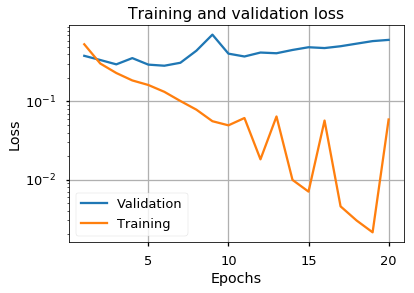

In [80]:
plot_metric(h, 'loss')

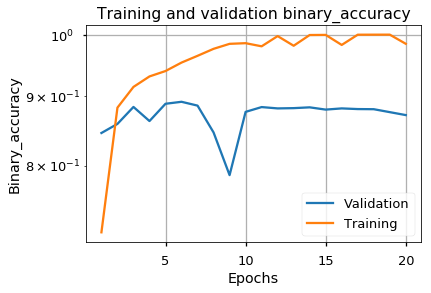

In [81]:
plot_metric(h, 'binary_accuracy')

We cannot find a satisfactory model with what we have learned so far. Is there any way to have a better representation of text that can provide better results?

In [82]:
m.evaluate(x_test, test_labels)

25000/25000 [==============================] - 5s 192us/step


[0.6723394194018841, 0.85832]

# Word embeddings

Using 1-HOT encoded vectors produce large and sparse tensors, that are difficult to learn from using a neural network. Word embeddings are compact vectors, representing words in a vector space. These vectors are learnt in a neural network, with a layer of type *Embedding*. We can also even use pre-trained word embeddings, to improve our model

![](./imgs/07_embeddings.png)

To generate  an embedding, we need to tokenize the text, transforming words into indices, and then we use these lists of numbers to produce the vectorial representation:

![](./imgs/08_embeddings.png)

More info:
* http://www.offconvex.org/2015/12/12/word-embeddings-1/
* http://www.offconvex.org/2016/02/14/word-embeddings-2/

## Input data for word embeddings

In [29]:
max_words = 10000
max_len = 100  # maximum length of the reviews
embedding_dim = 32  # number of components of the embedding vector

In [30]:
from keras import preprocessing

In [31]:
x_train = preprocessing.sequence.pad_sequences(train_text, maxlen=max_len)

In [32]:
x_train.shape

(25000, 100)

In [33]:
x_train[0:5, 0:10]  # we are limiting the reviews to just 100 words, with a vocabulary of 10ˆ4 words

array([[1415,   33,    6,   22,   12,  215,   28,   77,   52,    5],
       [ 163,   11, 3215,    2,    4, 1153,    9,  194,  775,    7],
       [1301,    4, 1873,   33,   89,   78,   12,   66,   16,    4],
       [  40,    2,   13,  188, 1076, 3222,   19,    4,    2,    7],
       [  13,   16,  131, 2073,  249,  114,  249,  229,  249,   20]],
      dtype=int32)

In [34]:
x_test = preprocessing.sequence.pad_sequences(test_text, maxlen=max_len)

## Let's build the model with embeddings

In [35]:
# Try first with Dense layers,
# Then SimpleRNN without return_sequences
# Then with return_sequences
# Then several RNN layers
# Then show LSTM layers
def build_model():
    m = models.Sequential()
    m.add(layers.Embedding(max_words, embedding_dim))
    #m.add(layers.Dense(32, activation='relu'))
    #m.add(layers.SimpleRNN(32, return_sequences=True))        
    #m.add(layers.SimpleRNN(32, return_sequences=True))
    #m.add(layers.SimpleRNN(32, return_sequences=True))
    #m.add(layers.SimpleRNN(32, return_sequences=True))
    m.add(layers.LSTM(32, return_sequences=True))
    #m.add(layers.LSTM(32, return_sequences=True))
    m.add(layers.LSTM(32))
    m.add(layers.Dense(1, activation='sigmoid'))
    return m

In [36]:
m = build_model()

In [37]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 336,673
Trainable params: 336,673
Non-trainable params: 0
_________________________________________________________________


In [38]:
m.compile(
    optimizer=optimizers.rmsprop(),
    loss=losses.binary_crossentropy,
    metrics=[metrics.binary_accuracy]
)

In [40]:
h = m.fit(x_train, train_labels, epochs=10, batch_size=1024, validation_split=.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 13s 640us/step - loss: 0.5803 - binary_accuracy: 0.7158 - val_loss: 0.5077 - val_binary_accuracy: 0.7474
Epoch 2/10
20000/20000 [==============================] - 14s 723us/step - loss: 0.3977 - binary_accuracy: 0.8257 - val_loss: 0.3989 - val_binary_accuracy: 0.8254
Epoch 3/10
20000/20000 [==============================] - 15s 727us/step - loss: 0.3242 - binary_accuracy: 0.8665 - val_loss: 0.3898 - val_binary_accuracy: 0.8324
Epoch 4/10
20000/20000 [==============================] - 13s 630us/step - loss: 0.2914 - binary_accuracy: 0.8820 - val_loss: 0.3727 - val_binary_accuracy: 0.8394
Epoch 5/10
20000/20000 [==============================] - 13s 632us/step - loss: 0.2594 - binary_accuracy: 0.8994 - val_loss: 0.3912 - val_binary_accuracy: 0.8310
Epoch 6/10
20000/20000 [==============================] - 13s 641us/step - loss: 0.2317 - binary_accuracy: 0.9111 - val_loss: 0.4239 - v

## Analyze performance

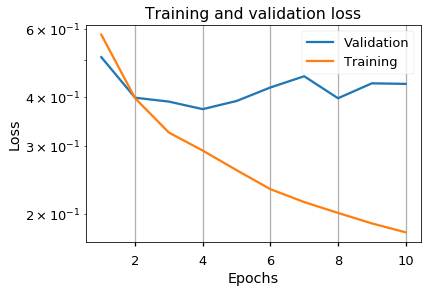

In [41]:
plot_metric(h, 'loss')

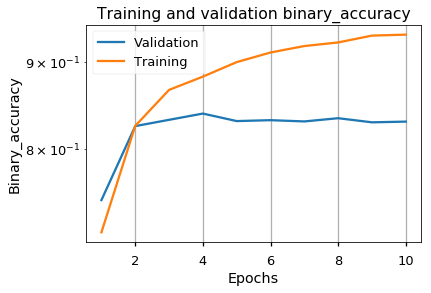

In [42]:
plot_metric(h, 'binary_accuracy')

Not bad, with just an embedding layer, we get $75\%$ accuracy

In [43]:
loss, acc = m.evaluate(x_test, test_labels)

25000/25000 [==============================] - 19s 748us/step


In [44]:
loss, acc

(0.43535898880958557, 0.83044)

How many reviews will be misclassified?

In [45]:
(1-acc)*len(test_labels)

4239.000000000001

Let's check some of the predictions

In [46]:
N = 123
# N = 2344

In [47]:
m.predict(x_test[N:N+1,])[0][0] >= 0.5

True

In [48]:
test_labels[N]

1

So this prediction is correct. It says the review is negative. Let's have a look at the text:

In [49]:
get_text_from_vector(test_text[N])

"? if you believe that any given war movie can make you really feel the war you need to see called the ? are flying in english it tells the story of ? ? and boris who are in love on the verge of wwii they are walking along the ? watching the ? fly by when the war starts boris is promptly sent off to war ? hides out with a family and ends up marrying the son whom she does not love boris meanwhile continues ? through the countryside fighting the nazis and experiencing all the horrors of war until he he runs out of energy when ? working in a military hospital receives this news she refuses to accept it until ? body arrives home on one of the trains simultaneously the radio ? that germany has ? and the allied powers have won the war the soviet union lost 27 million citizens but it's the start of a new era br br this movie did a very good job showing the human impact of the war not only in the battlefield but also how it affected the ? population this is definitely a movie that everyone sho

Can we find all the reviews that are wrongly classified?

In [50]:
preds = m.predict(x_test)

In [51]:
preds.shape

(25000, 1)

In [52]:
preds[0:10]

array([[0.16714993],
       [0.99078965],
       [0.9797499 ],
       [0.55139786],
       [0.99386793],
       [0.7385477 ],
       [0.9899457 ],
       [0.01698123],
       [0.9646337 ],
       [0.9895983 ]], dtype=float32)

In [53]:
preds_binary = (preds >= 0.5).reshape((len(preds),))

In [54]:
preds_binary.shape

(25000,)

In [55]:
test_labels.shape

(25000,)

In [56]:
wrong_pos = np.where(test_labels != preds_binary)[0]

In [57]:
wrong_pos.shape

(4239,)

In [58]:
wrong_pos[0:100]

array([  3,   8,  17,  32,  38,  45,  59,  66,  75,  80,  81,  95,  98,
       100, 101, 112, 115, 126, 139, 146, 152, 154, 156, 159, 166, 167,
       182, 191, 205, 214, 227, 232, 247, 248, 256, 267, 274, 282, 283,
       296, 299, 300, 302, 310, 319, 328, 330, 333, 336, 339, 342, 345,
       346, 348, 349, 355, 356, 358, 367, 372, 376, 378, 386, 389, 399,
       414, 417, 422, 433, 438, 447, 449, 455, 476, 488, 491, 495, 503,
       505, 524, 537, 544, 547, 548, 556, 558, 562, 570, 573, 576, 581,
       593, 598, 612, 613, 614, 629, 634, 641, 653])

In [59]:
preds_binary[3], preds[3][0]

(True, 0.55139786)

In [60]:
test_labels[3]

0

In [61]:
get_text_from_vector(test_text[3])

"? i generally love this type of movie however this time i found myself wanting to kick the screen since i can't do that i will just complain about it this was absolutely idiotic the things that happen with the dead kids are very cool but the alive people are absolute idiots i am a grown man pretty big and i can defend myself well however i would not do half the stuff the little girl does in this movie also the mother in this movie is reckless with her children to the point of neglect i wish i wasn't so angry about her and her actions because i would have otherwise enjoyed the flick what a number she was take my advise and fast forward through everything you see her do until the end also is anyone else getting sick of watching movies that are filmed so dark anymore one can hardly see what is being filmed as an audience we are ? involved with the actions on the screen so then why the hell can't we have night vision"

Is the classifier symmetric?

In [62]:
fp_pos = wrong_pos[test_labels[wrong_pos] == 0]

In [63]:
fp_pos.shape

(2818,)

In [64]:
fn_pos = wrong_pos[test_labels[wrong_pos] == 1]

In [65]:
fn_pos.shape

(1421,)

<BarContainer object of 2 artists>

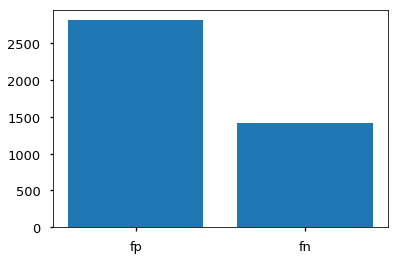

In [66]:
plt.bar(['fp','fn'],[fp_pos.shape[0],fn_pos.shape[0]])

**EXERCISE** Can you construct the confusion matrix for this model? Can you calculate the precision and recall? How does it compare to accuracy?
* See https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

**EXERCISE (more complex)** Keras decided some time ago to remove precision, recall and F1-score from the list of available metrics. Was it a good decision? Why? Why did the Keras' authors did not remove accuracy too?
* https://github.com/keras-team/keras/issues/5794
* https://github.com/keras-team/keras/issues/4592

**EXERCISE** What is the ROC curve? Could you build the ROC curve for this model? How would you use a ROC curve to evaluate a classifier?
* https://en.wikipedia.org/wiki/Receiver_operating_characteristic
* Help: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

In [67]:
from sklearn import metrics

In [68]:
roc = metrics.roc_curve(test_labels, preds)

In [69]:
roc

(array([0.     , 0.     , 0.     , ..., 0.99832, 0.99848, 1.     ]),
 array([8.00e-05, 4.72e-03, 4.88e-03, ..., 1.00e+00, 1.00e+00, 1.00e+00]),
 array([0.9956527 , 0.9948921 , 0.9948901 , ..., 0.00601855, 0.00601442,
        0.00519402], dtype=float32))

In [70]:
auc = metrics.roc_auc_score(test_labels, preds)

In [71]:
auc

0.9139120288

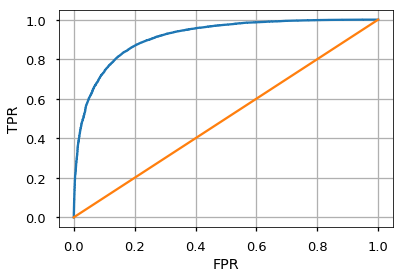

In [72]:
fpr, tpr, _ = roc
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1],'-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()

Let's analyze wrong positives and wrong negatives separately. Then we will try to find a relationship between the words and the misclassification, both for false positives and negatives.

In [73]:
fp_pos.shape

(2818,)

In [74]:
def words_hist(pos, texts):
    words_hist = {}

    for p in pos:
        ws = get_text_from_vector(texts[p]).split(' ')
        for w in ws:
            if w in words_hist.keys():
                words_hist[w] += 1
            else:
                words_hist[w] = 1
        
    return words_hist

In [75]:
fp_words = words_hist(fp_pos, test_text)

Now let's compare with the words of the true positives

In [76]:
tp_pos = np.where(test_labels == preds_binary)[0]

In [77]:
tp_pos.shape

(20761,)

In [78]:
tp_words = words_hist(tp_pos, test_text)

In [79]:
import pandas as pd

In [80]:
fp_df = pd.DataFrame.from_dict(fp_words, orient='index')
tp_df = pd.DataFrame.from_dict(tp_words, orient='index')

In [84]:
fp_df.head()

,0
?,40563
i,8837
generally,57
love,653
this,8159


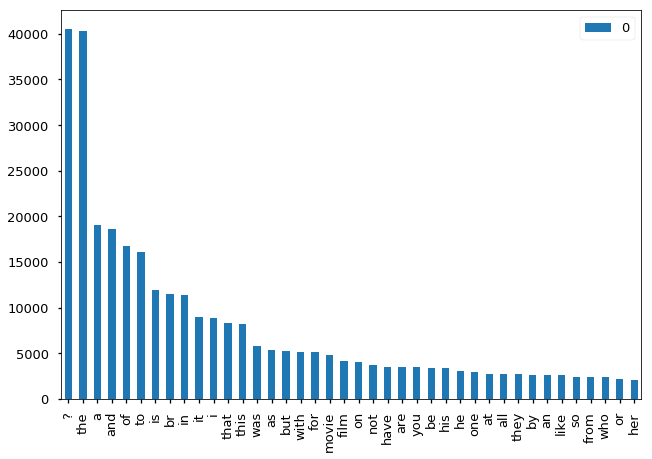

In [94]:
fp_df.sort_values(by=0, ascending=False)[0:40].plot.bar()

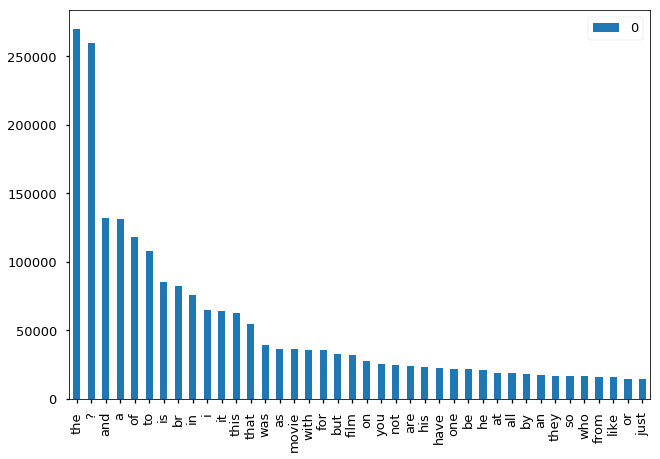

In [95]:
tp_df.sort_values(by=0, ascending=False)[0:40].plot.bar()

So the most common words are very similar. Not surprising. Let's calculate the relative frequency of each word, and then find what are the words with the highest difference in relative frequency.

In [106]:
tp_df['f'] = tp_df[0]/tp_df[0].sum()*100
fp_df['f'] = fp_df[0]/fp_df[0].sum()*100

In [107]:
fp_df.head()

,0,f
?,40563,5.868142
i,8837,1.278425
generally,57,0.008246
love,653,0.094468
this,8159,1.180341


In [108]:
tp_df.head()

,0,f
?,259613,5.497501
please,871,0.018444
give,2746,0.058149
this,62623,1.326089
one,21991,0.465676


In [110]:
diffs = tp_df-fp_df

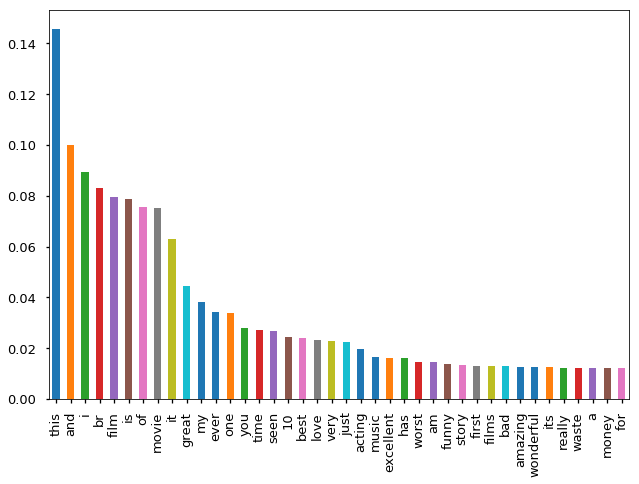

In [114]:
diffs.sort_values(by='f', ascending=False)[0:40]['f'].plot.bar()

We see words such as *great*, *best*, *excellent*, which have a large difference between the true and the false positives. So false positives seem to lack some extreme words, and the classifier is having a hard time trying to assign a category to those reviews.